In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output
import json

In [3]:
from utils.imdb_ratings import movies_with_imdb_rating
from utils.cluster_interpretation import plot_topic_distribution

# What isn't included in this notebook

This project required a lot of preprocessing, which is an interesting task, but is not related to the research questions. In this notebook we will focus on the research questions only.

For extracting characters and their attributes from the plot texts, refer to `extract_character_attributes.ipynb`.

For the clustering method please refer to `clustering.ipynb`, there you can find the methods comparison and the pipeline for characters clustering.

# Load the data

In [4]:
characters =  pd.read_csv(
    'data/character_clusters.csv', 
    index_col=0,
    converters={
        "adj": lambda x: x.strip("[]").replace("'","").split(", "), # need this to read list columns from csv
        "active": lambda x: x.strip("[]").replace("'","").split(", "),
        "patient": lambda x: x.strip("[]").replace("'","").split(", ")
        }
    )

movies = pd.read_csv(
    'data/MovieSummaries/movie.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'title', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']
)

actors = pd.read_csv(
    'data/MovieSummaries/character.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'release_date', 'character', 'date_of_birth', 'sex', 'height', '.','actor','age','character_map','..','...','....']
)

In [5]:
cpi_data = pd.read_csv('data/cpi_data.csv', )
cpi_data.head()

,year,cpi
0,1913,9.9
1,1914,10.0
2,1915,10.1
3,1916,10.9
4,1917,12.8


In [6]:
def same_name(names1, names2):
    names1 = names1.values
    names2 = names2.values
    flag = []
    for i in range(len(names1)):
        flag.append(names1[i] in names2[i])
    return flag


actors_and_characters = characters.merge(actors, how='left', left_on='wiki_id', right_on='wiki_id').dropna(subset=['character_y'])

actors_and_characters = actors_and_characters[same_name(actors_and_characters['character_x'], actors_and_characters['character_y'])]
actors_and_characters['character'] = actors_and_characters['character_x']
actors_and_characters = actors_and_characters.drop(columns=['character_x', 'character_y'])
actors_and_characters = actors_and_characters[['character', 'actor', 'cluster', 'wiki_id', 'release_date', 'date_of_birth', 'sex', 'height', 'age', 'adj', 'active', 'patient']]
actors_and_characters.sample(5)

,character,actor,cluster,wiki_id,release_date,date_of_birth,sex,height,age,adj,active,patient
82996,Mike Tobacco,Grant Cramer,16,1249019,1988-05-27,1961-11-10,M,NaN,26.0,[],"[see, travel, run, find, mourn]",[believe]
155104,Ayten,Nurgül Yeşilçay,3,13399638,2007-09-27,1976-03-26,F,1.65,31.0,"[daughter, member]","[become, search, have, grab]","[free, free, offer]"
409867,Niedermann,Micke Spreitz,40,24155032,2009-11-27,1964-07-05,M,1.98,45.0,[strongman],"[remain, break, hide, attempt]","[send, kill]"
444139,Hiroki Sugimura,Sousuke Takaoka,28,304692,2000-12-16,1982-02-08,M,NaN,18.0,[],"[search, rescue, track, profess]",[]
644414,Shyam,Shammi Kapoor,10,10702360,1961,1931-10-21,M,1.85,29.0,[name],"[arrive, see, sneak, leave, see]",[ask]


In [7]:
def discount_revenue(year, revenue):
    if year in cpi_data['year'].values:
        cpi = cpi_data[cpi_data['year'] == year]['cpi'].values[0]
    else:
        cpi = 100
    return (revenue /  cpi)*100


map_dict_to_list = lambda x: [value for key, value in eval(x).items()]
release_year = lambda x: pd.to_numeric(x.str.replace(r'-\d{2}-\d{2}$', '', regex=True).str.replace(r'-\d{2}$', '', regex=True))

movies['languages'] = movies['languages'].apply(map_dict_to_list)
movies['countries'] = movies['countries'].apply(map_dict_to_list)
movies['genres'] = movies['genres'].apply(map_dict_to_list)

movies["release_year"] = release_year(movies['release_date'])
movies["release_year"] = movies['release_year'].apply(lambda x: x if x > 1800 else x + 1000)

movies['discounted_revenue'] = movies.apply(lambda x: discount_revenue(x.release_year, x.revenue), axis=1)

movies.head()

,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,release_year,discounted_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,7.911255e+06
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000.0,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],1983.0,NaN


In [8]:
%%script false --no-raise-error
# Script takes time to run, so we will use saved version instead
movies_with_rating = movies_with_imdb_rating(movies)

In [9]:
movies_with_rating = pd.read_csv(
    'data/movies_with_rating.csv', 
    index_col=0,
    converters={
        "languages": map_dict_to_list,
        "countries": map_dict_to_list,
        "genres": map_dict_to_list
        }
    )
    
movies_with_rating['release_year'] = release_year(movies_with_rating['release_date'])
movies_with_rating['discounted_revenue'] = movies_with_rating.apply(lambda x: discount_revenue(x.release_year, x.revenue), axis=1)

movies_with_rating.head()

,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,averageRating,numVotes,release_year,discounted_revenue
0,10109752,/m/02q23xk,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]",5.3,208,1894,NaN
1,28703057,/m/0czdh_n,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,NaN,[],[],[Sports],5.3,485,1897,100000.0
2,142995,/m/0120y4,The Story of the Kelly Gang,1906-12-26,NaN,70.0,[English Language],[Australia],"[Crime Fiction, Silent film, Biography, Indie,...",6.0,855,1906,NaN
3,32986669,/m/04p7yxx,Robbery Under Arms,1907-11-02,NaN,NaN,[Silent film],[Australia],"[Silent film, Drama]",4.3,25,1907,NaN
4,15128675,/m/03hjcy9,Hamlet,1908,NaN,NaN,[French Language],[France],"[Silent film, Drama]",2.9,27,1908,NaN


In [10]:
plots = pd.read_csv(
    'data/MovieSummaries/plot_summaries.txt', 
    sep='\t', 
    names=['wiki_id', 'plot']
)
movies_and_plots = movies.merge(plots, how='right', left_on='wiki_id', right_on='wiki_id')
num_plot = len(pd.unique(movies_and_plots['wiki_id']))

In [11]:
characters_and_movies = characters.merge(movies, left_on='wiki_id', right_on='wiki_id')
num_char = len(pd.unique(characters_and_movies['wiki_id']))

### First look at the data

In [12]:
print(f"Number of movies: {len(movies)}")
print(f"Number of movies with revenue: {movies['revenue'].notna().sum()}")
print(f"Number of movies with rating: {len(movies_with_rating)}")
print(f"Number of movies with rating and revenue: {movies_with_rating['revenue'].notna().sum()}")
print(f"Number of movies with plot: {num_plot}")
print(f"Number of movies, where we find archetypes: {num_char}")
print(f"Number of actors with the characters who have an archetype: {len(actors_and_characters)}")

Number of movies: 81741
Number of movies with revenue: 8401
Number of movies with rating: 39886
Number of movies with rating and revenue: 7339
Number of movies with plot: 42303
Number of movies, where we find archetypes: 25604
Number of actors with the characters who have an archetype: 29724


In [13]:
print(f"Number of characters with archetypes: {len(characters)}")
print(f"Number of actors: {len(actors)}")
print(f"Number of actors with the characters who have an archetype: {len(actors_and_characters)}")

Number of characters with archetypes: 74842
Number of actors: 450669
Number of actors with the characters who have an archetype: 29724


In [14]:
print(f"Number of actors with the characters who have an archetype in the movies with revenue and rating: {len(actors_and_characters[actors_and_characters['wiki_id'].isin(movies_with_rating[movies_with_rating['revenue'].notna()]['wiki_id'])])}")

Number of actors with the characters who have an archetype in the movies with revenue and rating: 13839


### What are the countries of production

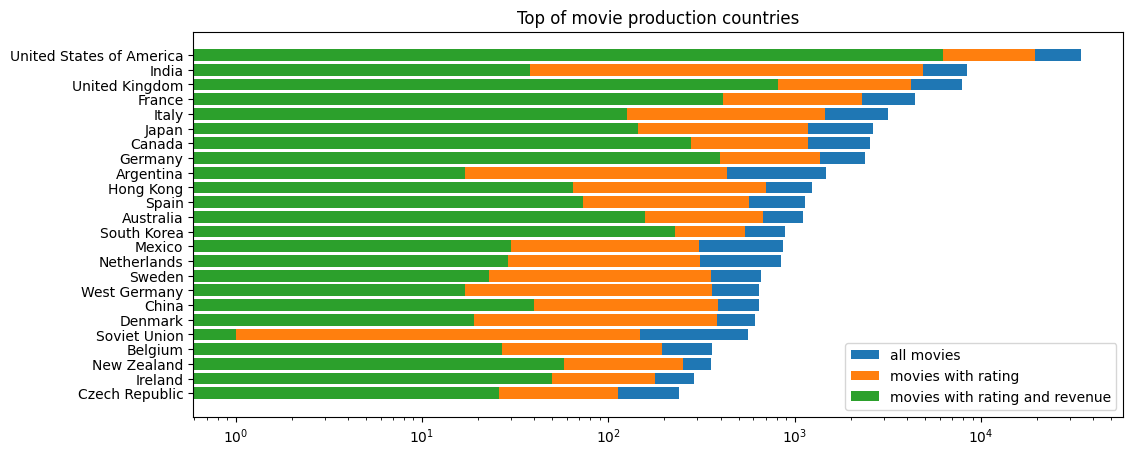

In [15]:
coutries_distr = movies.explode('countries').groupby('countries').size()
coutries_distr_with_rating = movies_with_rating.explode('countries').groupby('countries').size()
coutries_distr_with_rating_and_revenue = movies_with_rating[movies_with_rating['revenue'].notna()].explode('countries').groupby('countries').size()

coutries = list(set(
    coutries_distr.sort_values(ascending=False)[:20].index.to_list() 
    + coutries_distr_with_rating.sort_values(ascending=False)[:20].index.to_list() 
    + coutries_distr_with_rating_and_revenue.sort_values(ascending=False)[:20].index.to_list()))

coutries_distr = coutries_distr.loc[coutries].sort_values(ascending=True)
coutries = coutries_distr.index.to_list() 
coutries_distr_with_rating = coutries_distr_with_rating.loc[coutries]
coutries_distr_with_rating_and_revenue = coutries_distr_with_rating_and_revenue.loc[coutries]

plt.figure(figsize=(12, 5))
plt.title('Top of movie production countries')

plt.barh(coutries_distr.index, coutries_distr.values, label='all movies')
plt.barh(coutries_distr_with_rating.index, coutries_distr_with_rating.values, label='movies with rating')
plt.barh(coutries_distr_with_rating_and_revenue.index, coutries_distr_with_rating_and_revenue.values, label='movies with rating and revenue')

plt.xscale('log')
plt.legend()

plt.show()

We can notice that most of the movies in the dataset are made in the US, moreover, we have much less data for movies with revenue and this data is't distributed prportionally to the overall number of movies produced in the country.

### What is the historical distribution

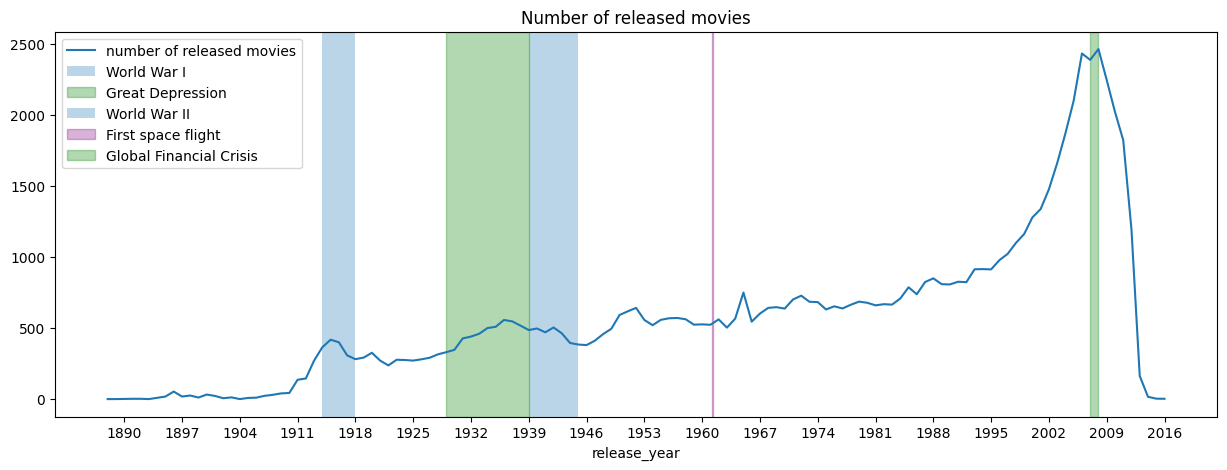

In [16]:
movies.groupby('release_year').size().plot(figsize=(15, 5), title='Number of released movies', label='number of released movies')
plt.xticks(np.arange(1890, 2021, 7))

plt.axvspan(1914, 1918, alpha=0.3, label='World War I')
plt.axvspan(1929, 1939, alpha=0.3, label='Great Depression', color='green')
plt.axvspan(1939, 1945, alpha=0.3, label='World War II')
plt.axvspan(1961.2, 1961.3, alpha=0.3, label='First space flight', color='purple')
plt.axvspan(2007, 2008, alpha=0.3, label='Global Financial Crisis', color='green')

plt.legend()

plt.show()

We don't have much data before 1910-s and after 2012.

# Clusters interpretation
To interpret clusters, we can use the function `plot_topic_distribution` to see the topics with the largest probabilities to be in the cluster.

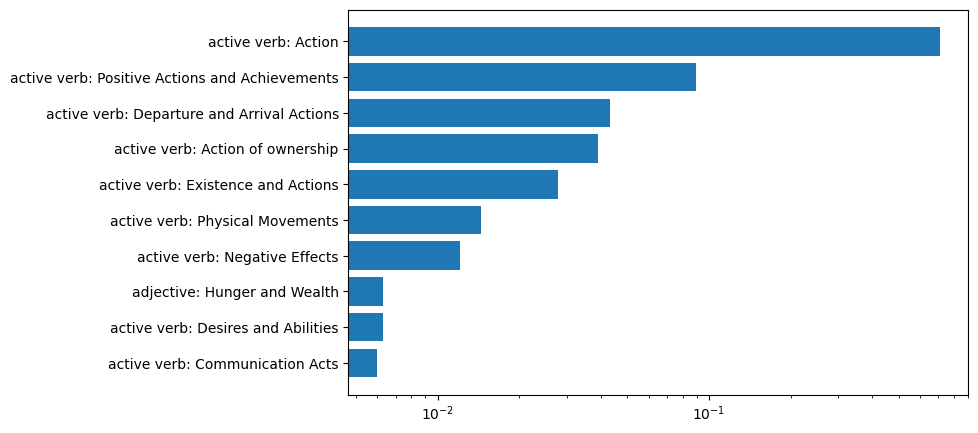

In [17]:
plot_topic_distribution(42)

# Historycal trends

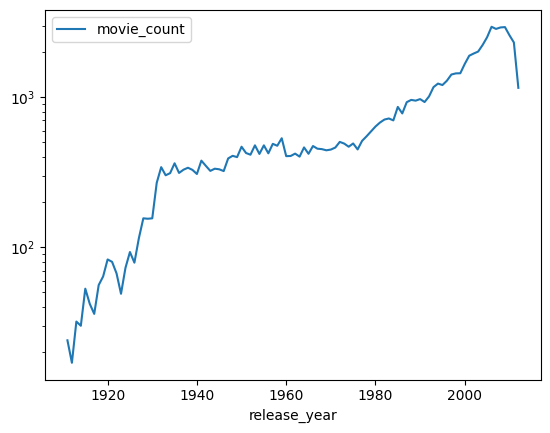

In [18]:
movies_count = characters_and_movies.groupby('release_year').size().reset_index(name='movie_count')
movies_count = movies_count[movies_count['movie_count'] >= 15]
movies_count.plot(x='release_year', y='movie_count')
plt.yscale('log')

Comment: We decide to analyze trends where there is a stable abundance of data, and remove movies before 1932 and tha last two years (2013-2014). For further analysis we are selecting important clusters (by relative popularity or changes in popularity) but this selection is skewed by the years where there is little data since that gives a very high proportion for every cluster. So the early clusters will appear very significant despite that not being the case (if e.g. there are only a handful of movies, the archetype distribution is not very interesting). Therefore the filtered subset is used, not only for plot, but also for cluster ranking.

<AxesSubplot:xlabel='release_year'>

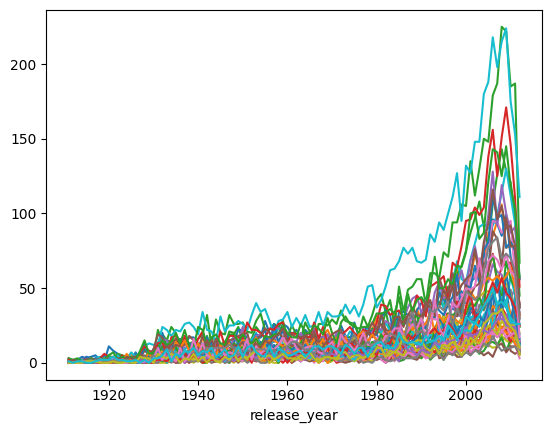

In [19]:
archetype_counts = characters_and_movies[characters_and_movies['release_year'].isin(movies_count['release_year'])].groupby(['release_year', 'cluster']).size().reset_index(name='character_count')
archetype_counts = archetype_counts.pivot(index='release_year', columns='cluster', values='character_count').fillna(0)
archetype_counts.plot(legend=False)

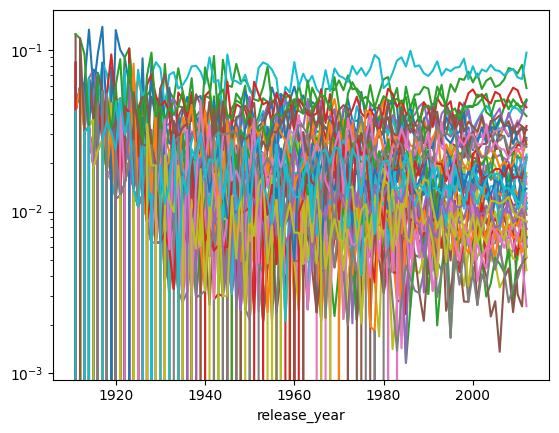

In [20]:
normalized_archetype_counts = (archetype_counts)/(archetype_counts.values.sum(1).reshape(-1, 1))
normalized_archetype_counts.plot(legend=False)
plt.yscale('log')

### Top archetypes

- By the highest sum of normalized frequency (popularity)
- By the biggest range in normalized frequency (changes in popularity)

In [21]:
# sum of normalized frequency

top_clusters = normalized_archetype_counts.sum(0).sort_values(ascending=False)[:10].index.values
top_clusters_archetype_counts = normalized_archetype_counts[top_clusters]
top_clusters_archetype_counts

cluster,19,12,42,33,10,35,2,24,30,9
release_year,,,,,,,,,,
1911.0,0.041667,0.000000,0.125000,0.000000,0.041667,0.000000,0.041667,0.000000,0.041667,0.000000
1912.0,0.000000,0.058824,0.117647,0.000000,0.058824,0.000000,0.058824,0.000000,0.058824,0.058824
1913.0,0.062500,0.000000,0.093750,0.000000,0.062500,0.000000,0.000000,0.031250,0.062500,0.000000
1914.0,0.000000,0.000000,0.033333,0.066667,0.133333,0.066667,0.000000,0.066667,0.033333,0.000000
1915.0,0.056604,0.056604,0.018868,0.037736,0.056604,0.037736,0.056604,0.056604,0.075472,0.018868
...,...,...,...,...,...,...,...,...,...,...
2008.0,0.073681,0.077108,0.042838,0.051748,0.029130,0.035984,0.049006,0.040781,0.033927,0.039068
2009.0,0.076346,0.075665,0.049421,0.058282,0.033742,0.030675,0.043626,0.034083,0.026244,0.044308
2010.0,0.067515,0.071373,0.045525,0.056327,0.027392,0.035494,0.046682,0.033565,0.031250,0.043210


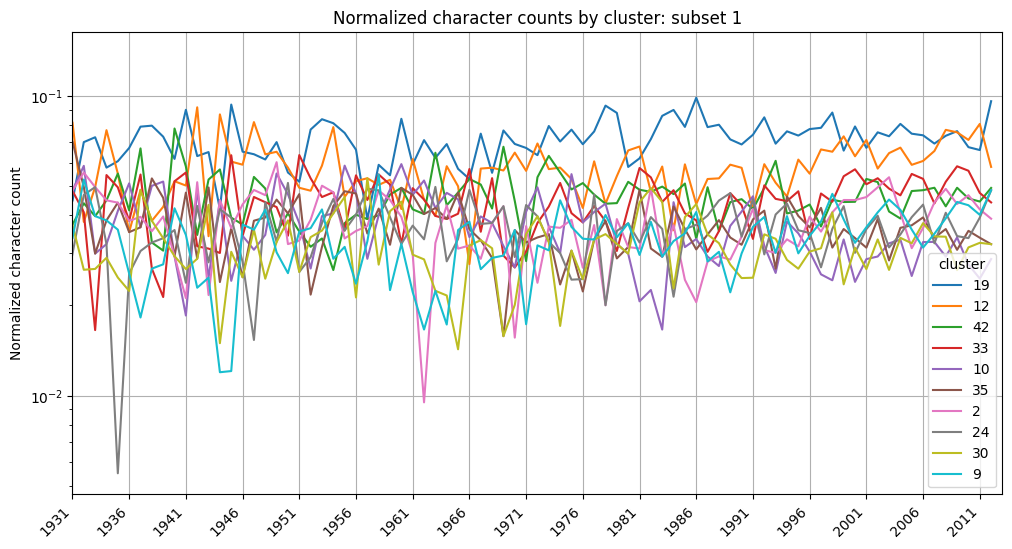

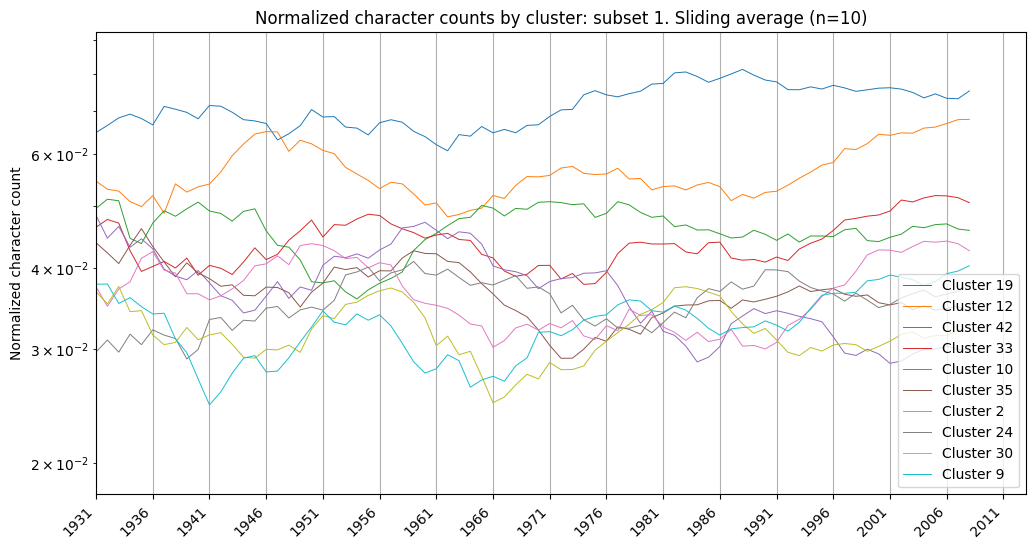

In [22]:
top_clusters_archetype_counts.plot(figsize=(12, 6))
plt.yscale("log")
plt.xticks(top_clusters_archetype_counts.index[::5], rotation=45, ha='right')
plt.xlim([1931, 2013])
plt.xlabel('')
plt.ylabel('Normalized character count')
plt.title('Normalized character counts by cluster: subset 1')
plt.grid(True)
plt.show()

# -----------------------------------
n = 10 # sliding average window size

plt.figure(figsize=(12, 6))

# Iterate over clusters and plot a line for each
for cluster in top_clusters:
    x = top_clusters_archetype_counts[cluster]
    x_avg = np.convolve(x, np.ones(n)/n, mode='valid')
    y = top_clusters_archetype_counts.index
    y_1 = y[round(n/2):-(n-round(n/2))+1]
    plt.plot(y_1, x_avg, label=f'Cluster {cluster}', marker='', linewidth=0.7)

plt.yscale("log")
plt.xticks(top_clusters_archetype_counts.index[::5], rotation=45, ha='right')
plt.xlim([1931, 2013])
plt.xlabel('')
plt.ylabel('Normalized character count')
plt.title(f'Normalized character counts by cluster: subset 1. Sliding average (n={n})')
plt.legend()
plt.grid(True)
plt.show()

#### Interpretation

In [23]:
def print_cluster_info(n):
    print('Cluster: ', n)
    top = characters_and_movies[(characters_and_movies['cluster'] == n) & (characters_and_movies['revenue'] > 5e8)]
    top = top.sort_values(by='revenue', ascending=False).head(5)
    print(top[['title', 'character']])
    plot_topic_distribution(n)

Cluster:  19
                                               title            character
50598                                        Titanic          Jack Dawson
50600                                        Titanic  Rose DeWitt Bukater
73920  Harry Potter and the Deathly Hallows – Part 2                 Wand
74358    Pirates of the Caribbean: On Stranger Tides         Jack Sparrow
35637       Harry Potter and the Philosopher's Stone         Harry Potter


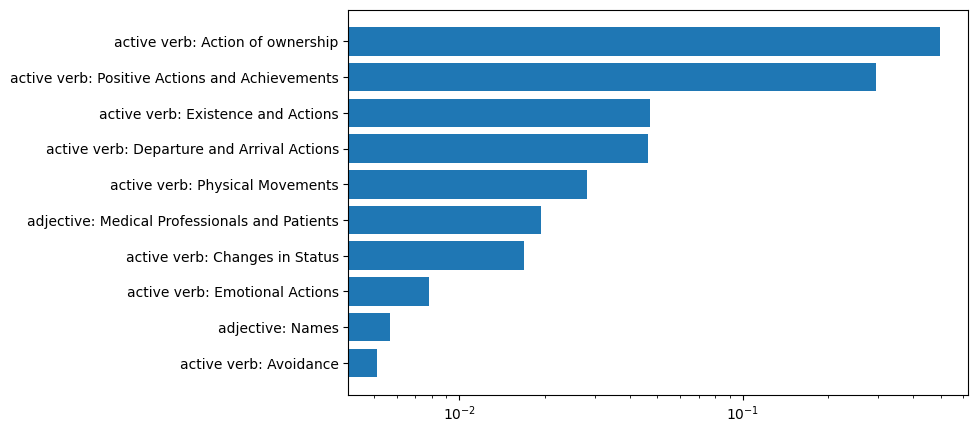

Cluster:  12
                                               title      character
54389                                         Avatar           Jake
66442                                   The Avengers           Thor
73918  Harry Potter and the Deathly Hallows – Part 2  Severus Snape
73990  The Lord of the Rings: The Return of the King         Pippin
73988  The Lord of the Rings: The Return of the King          Frodo


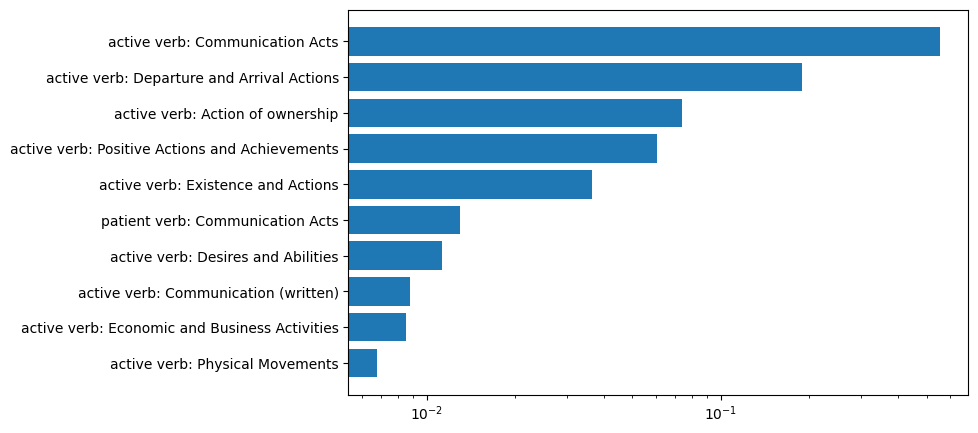

Cluster:  42
                                title         character
66440                    The Avengers  Natasha Romanoff
66446                    The Avengers      Bruce Banner
66445                    The Avengers         Nick Fury
66444                    The Avengers        Tony Stark
9195   Transformers: Dark of the Moon           Optimus


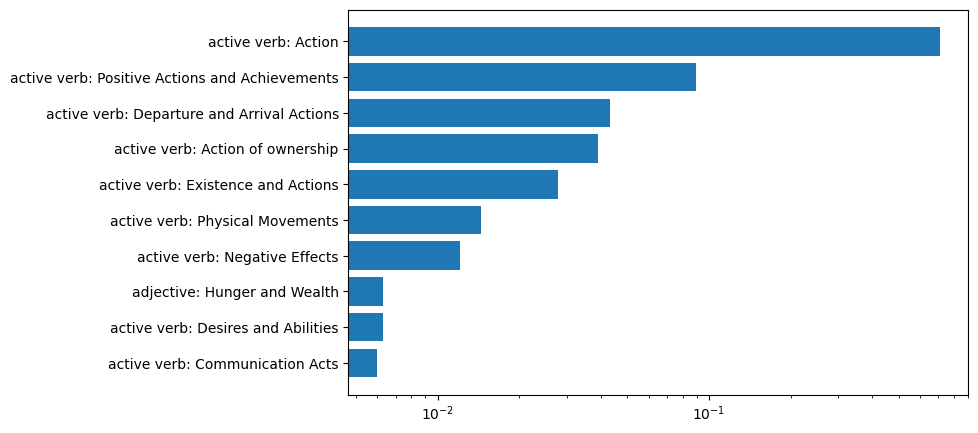

Cluster:  33
                            title     character
66441                The Avengers  Steve Rogers
19174       The Dark Knight Rises        Batman
15123             Shrek the Third          Puss
5358   E.T. the Extra-Terrestrial        Gertie
14969                Transformers     Bumblebee


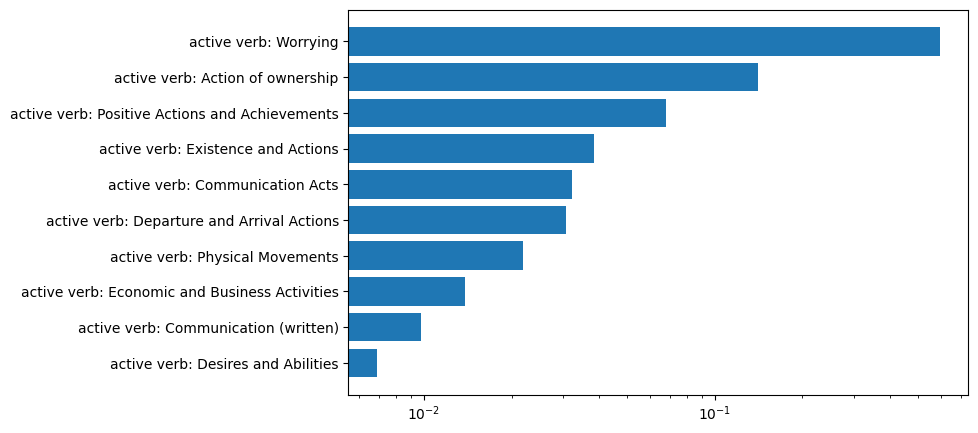

Cluster:  10
                                       title       character
71261  The Lord of the Rings: The Two Towers           Éomer
15578    Transformers: Revenge of the Fallen          Ravage
29595                       Independence Day  Jasmine Dubrow
53641                           Spider-Man 2    John Jameson
46342   Mission: Impossible – Ghost Protocol     Julia Meade


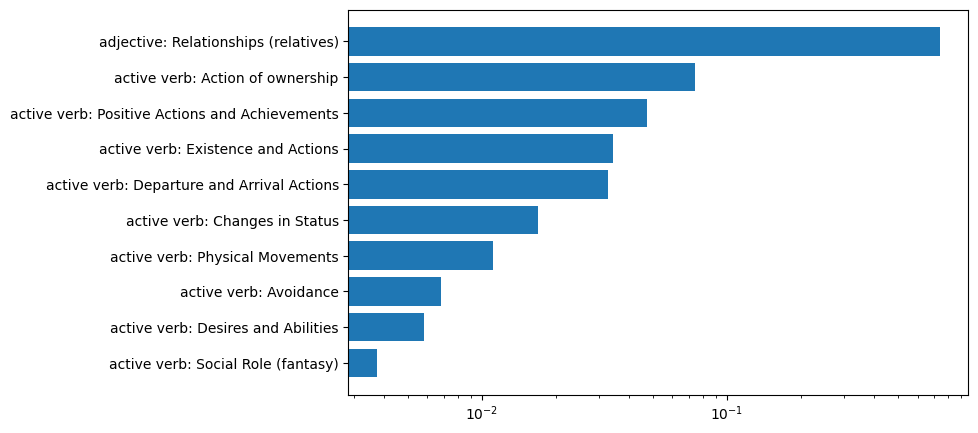

In [24]:
for cluster in top_clusters[:5]:
    print_cluster_info(cluster)

We can notice that three most popular archetypes are all archetypes of different kinds of protagonists and their close allies.

In [25]:
# biggest range in normalized frequency

top_diff_clusters = normalized_archetype_counts.apply(np.ptp).sort_values(ascending=False)[:10].index.values
top_clusters_archetype_counts = normalized_archetype_counts[top_diff_clusters]
top_clusters_archetype_counts

cluster,10,42,5,38,45,12,33,19,20,1
release_year,,,,,,,,,,
1911.0,0.041667,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.041667,0.083333,0.083333
1912.0,0.058824,0.117647,0.000000,0.117647,0.117647,0.058824,0.000000,0.000000,0.000000,0.000000
1913.0,0.062500,0.093750,0.000000,0.000000,0.031250,0.000000,0.000000,0.062500,0.031250,0.031250
1914.0,0.133333,0.033333,0.000000,0.000000,0.033333,0.000000,0.066667,0.000000,0.066667,0.000000
1915.0,0.056604,0.018868,0.037736,0.018868,0.000000,0.056604,0.037736,0.056604,0.037736,0.000000
...,...,...,...,...,...,...,...,...,...,...
2008.0,0.029130,0.042838,0.007539,0.009596,0.021933,0.077108,0.051748,0.073681,0.014393,0.036326
2009.0,0.033742,0.049421,0.008180,0.008180,0.033061,0.075665,0.058282,0.076346,0.012952,0.026244
2010.0,0.027392,0.045525,0.003086,0.009645,0.030093,0.071373,0.056327,0.067515,0.010417,0.030093


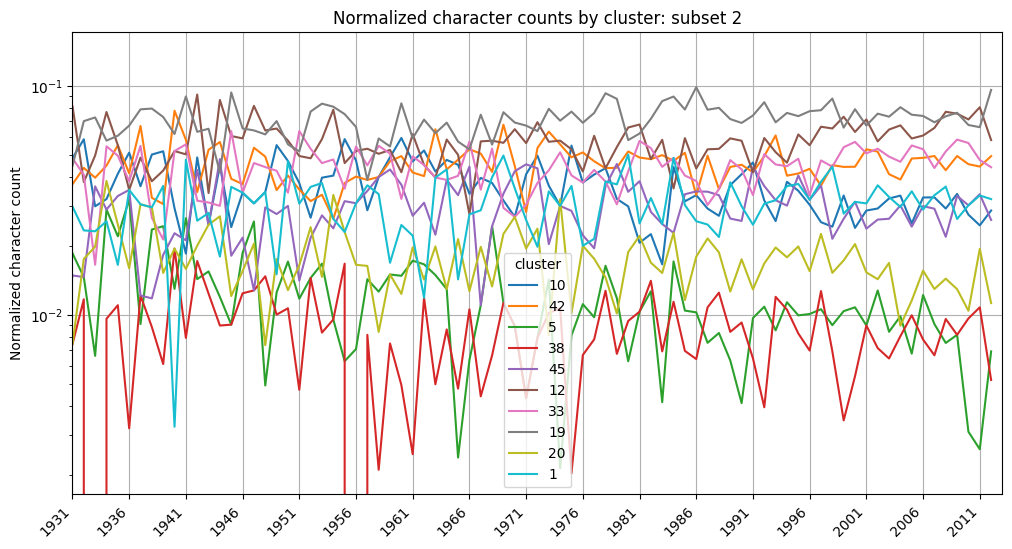

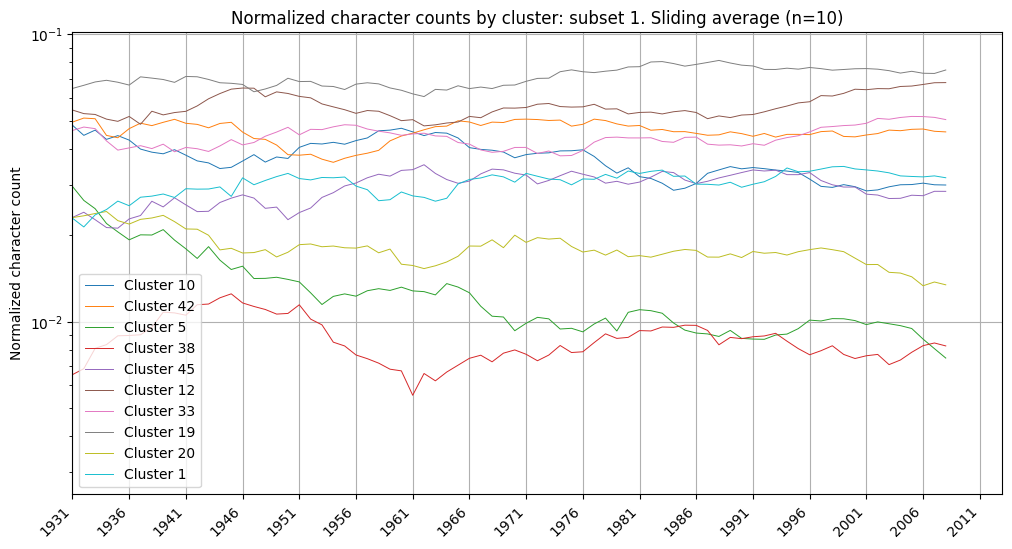

In [27]:
top_clusters_archetype_counts.plot(figsize=(12, 6))
plt.yscale("log")
plt.xticks(top_clusters_archetype_counts.index[::5], rotation=45, ha='right')
plt.xlim([1931, 2013])
plt.xlabel('')
plt.ylabel('Normalized character count')
plt.title('Normalized character counts by cluster: subset 2')
plt.grid(True)
plt.show()

# -----------------------------------
n = 10 # sliding average window size

plt.figure(figsize=(12, 6))

# Iterate over clusters and plot a line for each
for cluster in top_diff_clusters:
    x = top_clusters_archetype_counts[cluster]
    x_avg = np.convolve(x, np.ones(n)/n, mode='valid')
    y = top_clusters_archetype_counts.index
    y_1 = y[round(n/2):-(n-round(n/2))+1]
    plt.plot(y_1, x_avg, label=f'Cluster {cluster}', marker='', linewidth=0.7)

plt.yscale("log")
plt.xticks(top_clusters_archetype_counts.index[::5], rotation=45, ha='right')
plt.xlim([1931, 2013])
plt.xlabel('')
plt.ylabel('Normalized character count')
plt.title(f'Normalized character counts by cluster: subset 1. Sliding average (n={n})')
plt.legend()
plt.grid(True)
plt.show()

#### Interpretation

Cluster:  10
                                       title       character
71261  The Lord of the Rings: The Two Towers           Éomer
15578    Transformers: Revenge of the Fallen          Ravage
29595                       Independence Day  Jasmine Dubrow
53641                           Spider-Man 2    John Jameson
46342   Mission: Impossible – Ghost Protocol     Julia Meade


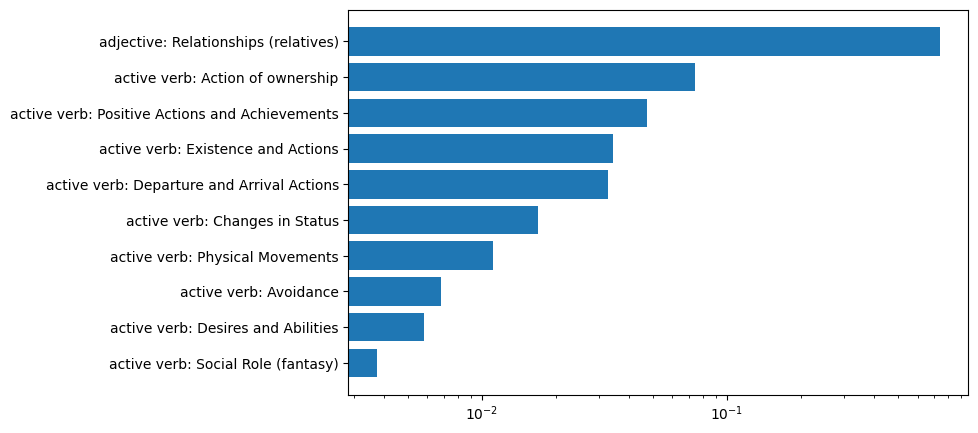

Cluster:  42
                                title         character
66440                    The Avengers  Natasha Romanoff
66446                    The Avengers      Bruce Banner
66445                    The Avengers         Nick Fury
66444                    The Avengers        Tony Stark
9195   Transformers: Dark of the Moon           Optimus


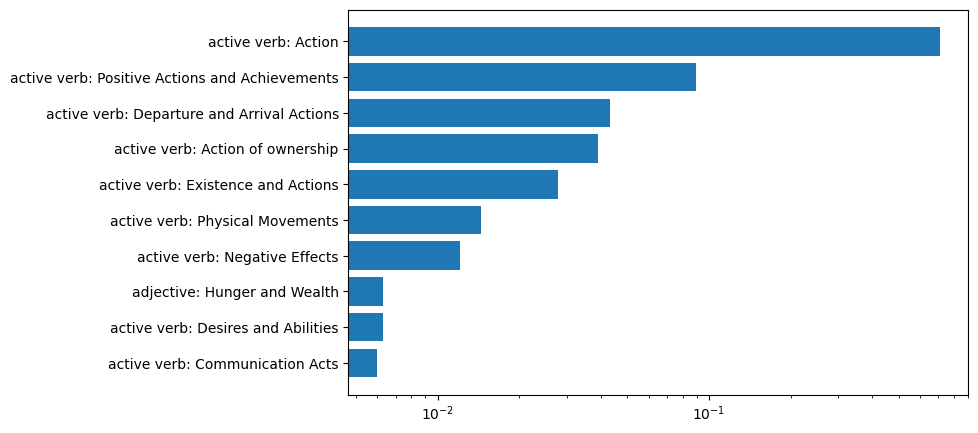

Cluster:  5
                                          title character
54131  Harry Potter and the Prisoner of Azkaban     Snape
63295                                Armageddon     Grace


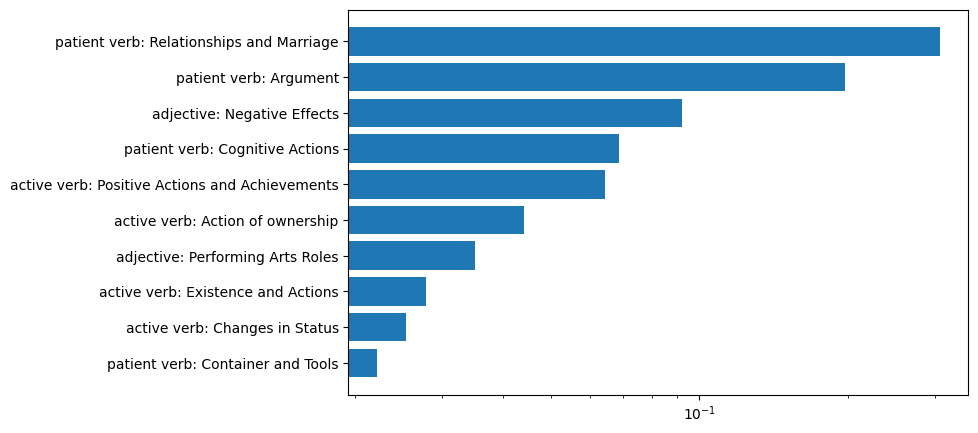

Cluster:  38
                                               title       character
73985  The Lord of the Rings: The Return of the King          Gollum
9881             Harry Potter and the Goblet of Fire  Cedric Diggory
35495                            Shrek Forever After            Puss
14967                                   Transformers   Mikaela Banes
61070                                        Eclipse         Cullens


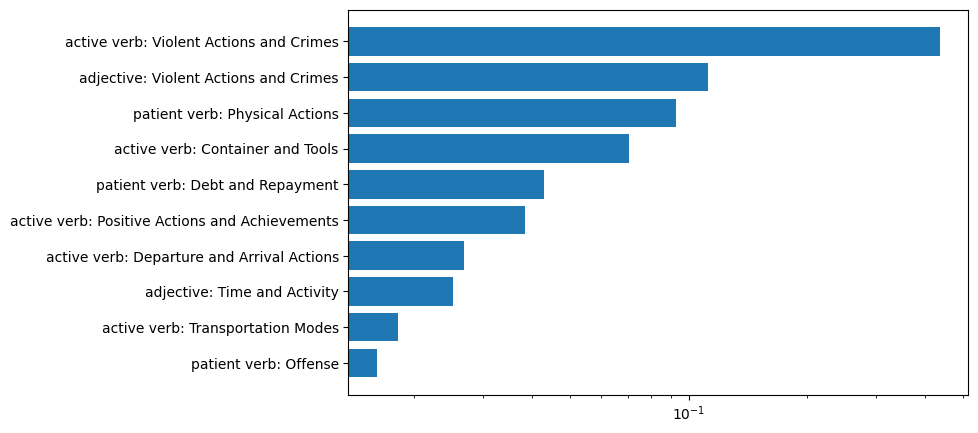

Cluster:  45
                                               title         character
54387                                         Avatar          Quaritch
66439                                   The Avengers      Clint Barton
73921  Harry Potter and the Deathly Hallows – Part 2  Hermione Weasley
73991  The Lord of the Rings: The Return of the King            Sauron
42228        Star Wars Episode I: The Phantom Menace      Jedi Knights


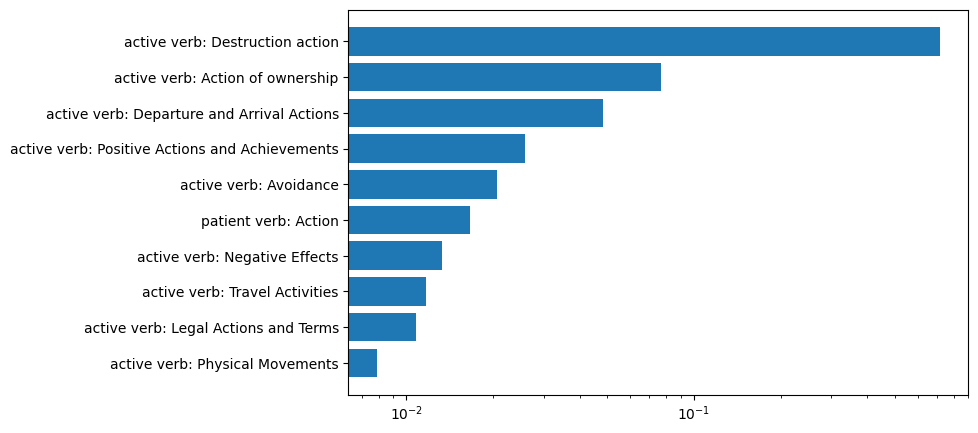

In [28]:
for cluster in top_diff_clusters[:5]:
    print_cluster_info(cluster)

The archetypes that changed in popularity the most are some side caracters.

# Cultural preference

We are interested in the cultural preferences at more modern times, so we will look only at the data from the 21 century. We also will use only the first country in the list of production countries.

In [29]:
char_movies_countries = characters_and_movies[characters_and_movies['release_year'] > 2000]
char_movies_countries['countries'] = char_movies_countries['countries'].apply(lambda x: x[0] if x else 'Unknown')

char_movies_countries = char_movies_countries.groupby(['countries', 'cluster']).size().reset_index(name='character_count')

char_movies_countries = char_movies_countries[['countries', 'cluster', 'character_count']]

/tmp/ipykernel_27075/2187779735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  char_movies_countries['countries'] = char_movies_countries['countries'].apply(lambda x: x[0] if x else 'Unknown')


In [30]:
# top production countries
char_movies_countries.groupby('countries')['character_count'].sum().sort_values(ascending=False)[:50].index

Index(['United States of America', 'India', 'Unknown', 'France', 'Japan',
       'United Kingdom', 'Canada', 'South Korea', 'Hong Kong', 'Australia',
       'Spain', 'Philippines', 'Thailand', 'Germany', 'Ireland', 'Italy',
       'China', 'Mexico', 'Russia', 'Denmark', 'Indonesia', 'Singapore',
       'Netherlands', 'South Africa', 'Malaysia', 'Austria', 'Sweden',
       'Belgium', 'Brazil', 'Argentina', 'Turkey', 'Poland', 'New Zealand',
       'Pakistan', 'England', 'Switzerland', 'Finland', 'Norway', 'Colombia',
       'Romania', 'Israel', 'Bangladesh', 'Iran', 'Cambodia', 'Serbia',
       'Iceland', 'Bulgaria', 'Burma', 'Taiwan', 'Nepal'],
      dtype='object', name='countries')

There are quite a lot of films with unknown country of production.

In [31]:
top_countries = char_movies_countries.groupby('countries')['character_count'].sum().sort_values(ascending=False)[:11].index
top_countries = top_countries.drop('Unknown')
top_countries

Index(['United States of America', 'India', 'France', 'Japan',
       'United Kingdom', 'Canada', 'South Korea', 'Hong Kong', 'Australia',
       'Spain'],
      dtype='object', name='countries')

In [32]:
char_movies_countries = char_movies_countries[char_movies_countries['countries'].isin(top_countries)]
archetype_by_country = char_movies_countries.pivot(index='countries', columns='cluster', values='character_count').fillna(0)
archetype_by_country

cluster,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
countries,,,,,,,,,,,,,,,,,,,,,
Australia,5.0,8.0,15.0,4.0,4.0,3.0,1.0,3.0,1.0,11.0,...,6.0,3.0,22.0,8.0,8.0,8.0,7.0,15.0,0.0,5.0
Canada,13.0,11.0,19.0,6.0,6.0,4.0,3.0,4.0,3.0,23.0,...,4.0,8.0,36.0,3.0,4.0,10.0,13.0,14.0,8.0,9.0
France,11.0,37.0,41.0,12.0,14.0,6.0,13.0,11.0,11.0,47.0,...,20.0,26.0,48.0,9.0,9.0,32.0,46.0,38.0,11.0,18.0
Hong Kong,3.0,23.0,11.0,8.0,5.0,10.0,11.0,7.0,3.0,10.0,...,10.0,12.0,24.0,14.0,3.0,15.0,8.0,8.0,7.0,6.0
India,36.0,176.0,162.0,37.0,34.0,80.0,17.0,58.0,30.0,170.0,...,40.0,108.0,136.0,96.0,36.0,94.0,76.0,118.0,29.0,68.0
Japan,8.0,24.0,39.0,16.0,9.0,4.0,7.0,9.0,6.0,37.0,...,11.0,15.0,59.0,18.0,13.0,29.0,29.0,21.0,6.0,12.0
South Korea,6.0,11.0,20.0,4.0,5.0,3.0,1.0,9.0,5.0,11.0,...,9.0,9.0,24.0,4.0,10.0,21.0,8.0,15.0,4.0,8.0
Spain,7.0,6.0,17.0,3.0,4.0,1.0,1.0,6.0,2.0,8.0,...,1.0,8.0,11.0,4.0,3.0,8.0,4.0,9.0,3.0,4.0
United Kingdom,9.0,26.0,46.0,15.0,5.0,4.0,6.0,11.0,11.0,33.0,...,9.0,17.0,24.0,18.0,9.0,18.0,30.0,20.0,11.0,19.0


<AxesSubplot:ylabel='countries'>

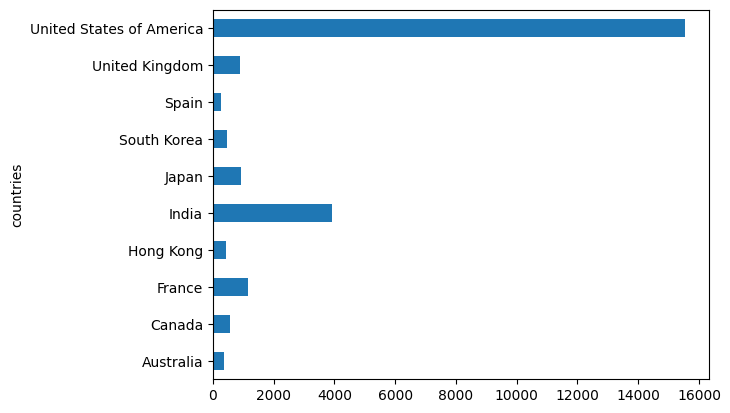

In [33]:
char_movies_countries.groupby('countries')['character_count'].sum().plot.barh(x='countries')

As we can see, we have much more data on the american films, so we will normalize the data. After that let's look at the distribution of the global top 5 archetypes.

<AxesSubplot:title={'center':'Distribution of the top 5 clusters in top 10 countries'}, ylabel='countries'>

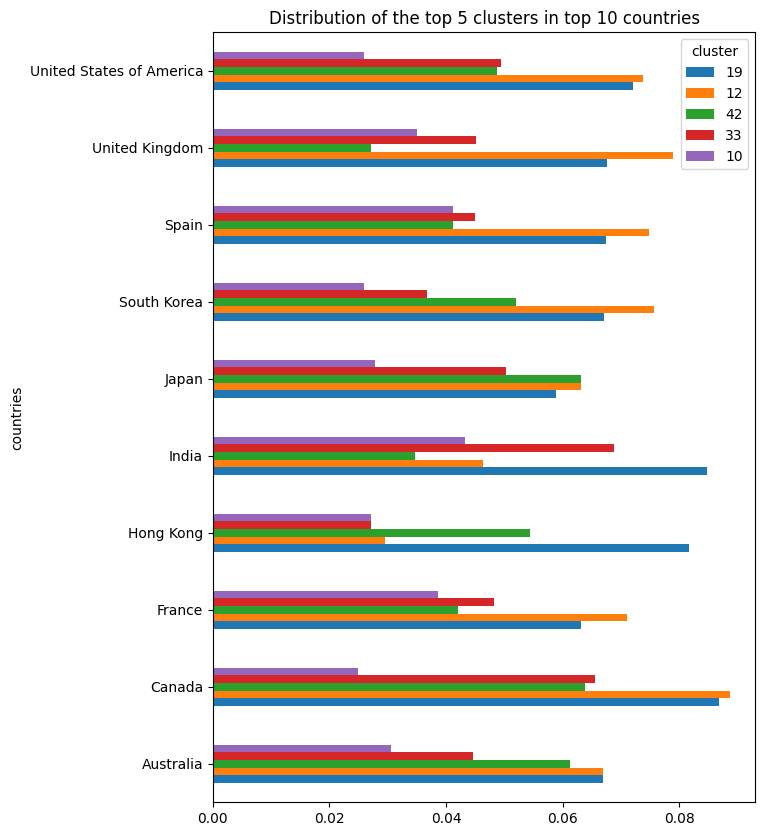

In [88]:
normalized_archetype_by_country = (archetype_by_country)/(archetype_by_country.values.sum(1).reshape(-1, 1))

normalized_archetype_by_country[top_clusters[:5]].plot.barh(figsize=(7, 10), title='Distribution of the top 5 clusters in top 10 countries')

It's easy to notice the difference between this countries. We can notice the difference in the types of the most popular protagonists for example in India and Hong Kong compared to United Kingdom and Spain. In the first group, the most popular protagonists are those who act and achieve something, while in the second group the most popular protagonists are communicating more and travel.

Now, we can't say, that the distribution of the archetypes is different in different countries. But was it the case in 20th century?

/tmp/ipykernel_27075/2994460840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  char_movies_countries['countries'] = char_movies_countries['countries'].apply(lambda x: x[0] if x else 'Unknown')


<AxesSubplot:title={'center':'Distribution of the top 5 clusters in top 10 countries in the 20th century'}, ylabel='countries'>

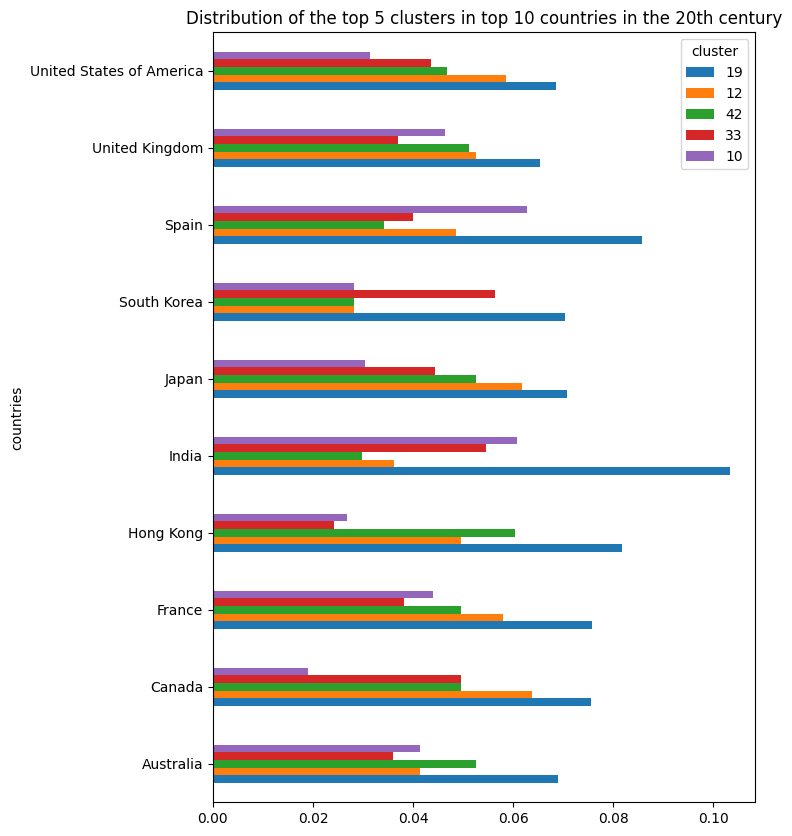

In [89]:
char_movies_countries = characters_and_movies[characters_and_movies['release_year'] < 2001]
char_movies_countries['countries'] = char_movies_countries['countries'].apply(lambda x: x[0] if x else 'Unknown')

char_movies_countries = char_movies_countries.groupby(['countries', 'cluster']).size().reset_index(name='character_count')

char_movies_countries = char_movies_countries[['countries', 'cluster', 'character_count']]

char_movies_countries = char_movies_countries[char_movies_countries['countries'].isin(top_countries)]
archetype_by_country = char_movies_countries.pivot(index='countries', columns='cluster', values='character_count').fillna(0)

normalized_archetype_by_country = (archetype_by_country)/(archetype_by_country.values.sum(1).reshape(-1, 1))

normalized_archetype_by_country[top_clusters[:5]].plot.barh(figsize=(7, 10), title='Distribution of the top 5 clusters in top 10 countries in the 20th century')

We can notice the shift that hapend from the 20th to 21st century from more achieving to communicating protagonists.

# Movie success based on the archetypes

# Actors success based on the archetypes